In [197]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

from sklearn.decomposition import SparseCoder

In [198]:
def drawPart(face_kps,drawimg,start,end,color,closed=True):
    for i in range(start,end+1):
        cv2.circle(drawimg,(face_kps[i,0],face_kps[i,1]),2,color,-1)
        if(i<end):
            cv2.line(drawimg,(face_kps[i,0],face_kps[i,1]),(face_kps[i+1,0],face_kps[i+1,1]),color,1)
        elif(closed):
            cv2.line(drawimg,(face_kps[end,0],face_kps[end,1]),(face_kps[start,0],face_kps[start,1]),color,1)
    return drawimg
def drawFace(kps): # keypose
    img = np.zeros((np.max(kps[...,0]*2),np.max(kps[...,1])*2,3),dtype='uint8')
    img = drawPart(kps,img,0,4,(255,0,0),False) # 左眉毛，非封闭区域
    img = drawPart(kps,img,5,9,(0,255,0),False) #右眉毛，非封闭区域
    img = drawPart(kps,img,10,15,(255,0,0)) # 左眼
    img = drawPart(kps,img,16,21,(0,255,0)) # 右眼
    img = drawPart(kps,img,22,25,(0,0,255),False) # 鼻梁，非封闭区域
    img = drawPart(kps,img,26,30,(0,0,255),False) # 鼻子，非封闭区域
    img = drawPart(kps,img,31,42,(0,255,255)) # 外嘴唇
    img = drawPart(kps,img,43,50,(255,0,255)) # 内嘴唇
    img = drawPart(kps,img,51,67,(255,255,0),False) # 脸轮廓，非封闭区域
    return img

10
10


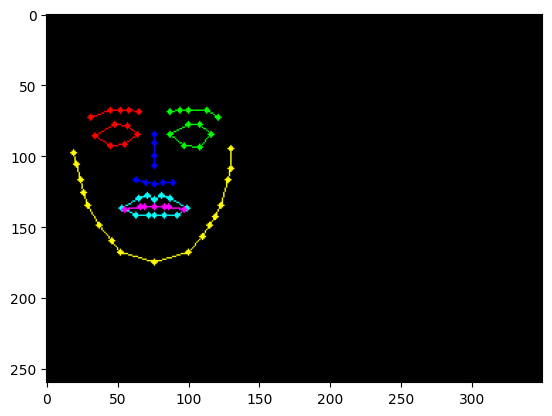

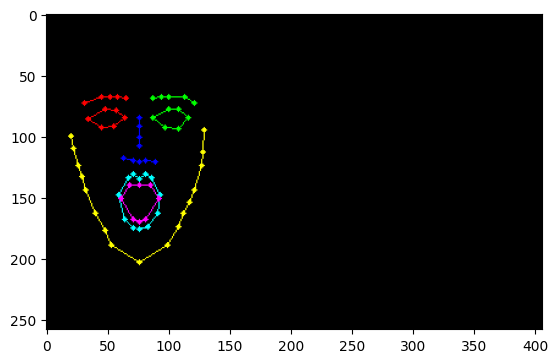

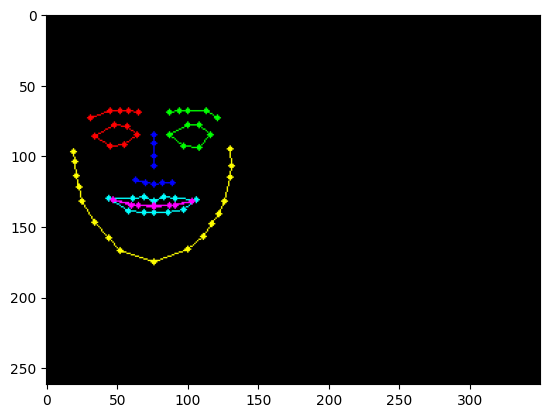

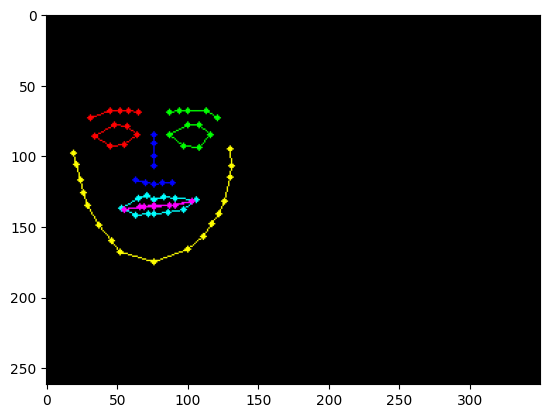

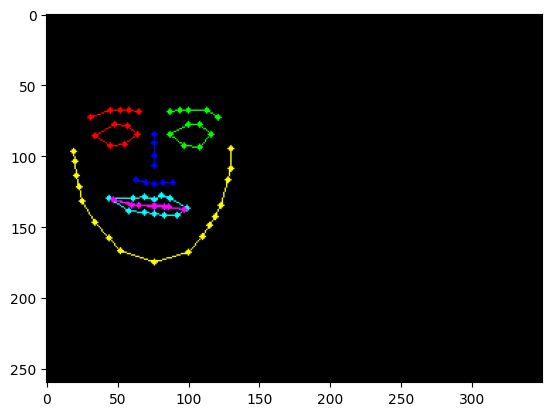

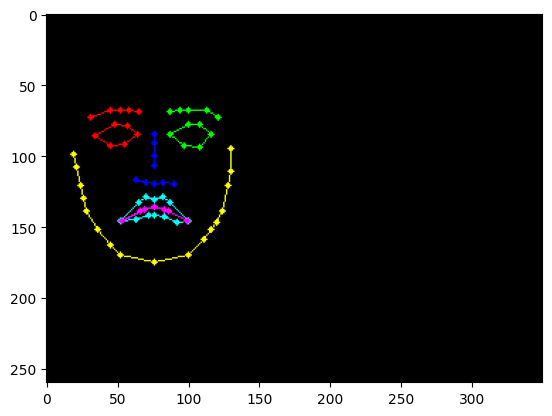

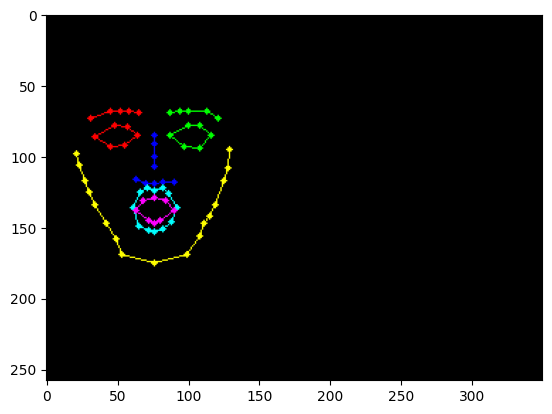

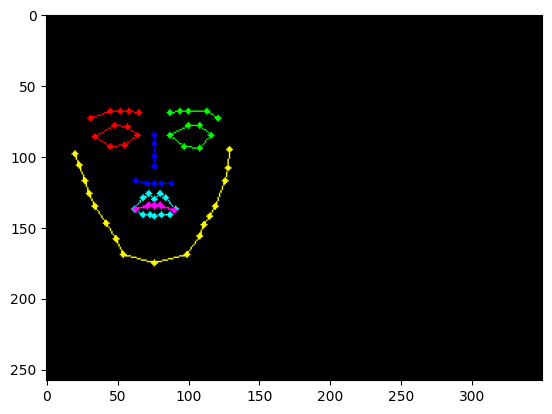

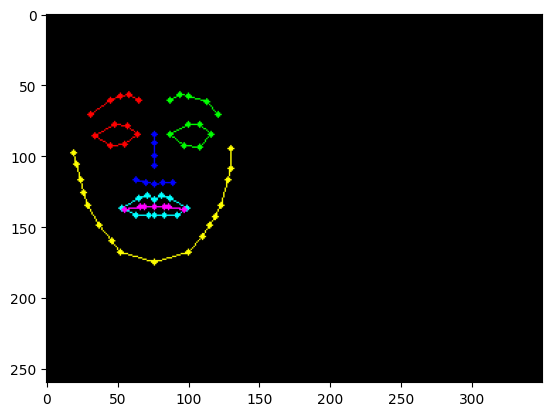

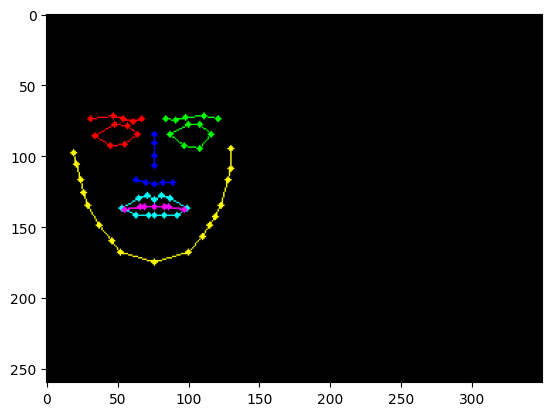

2
(68, 2)


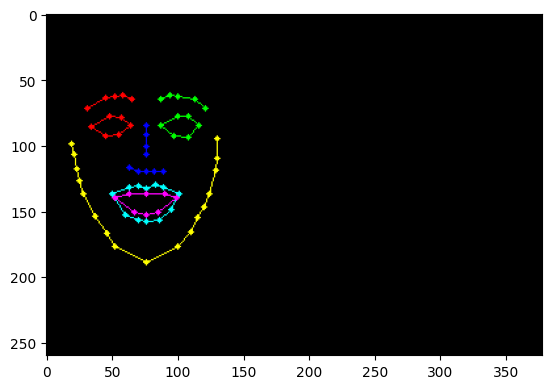

(68, 2)


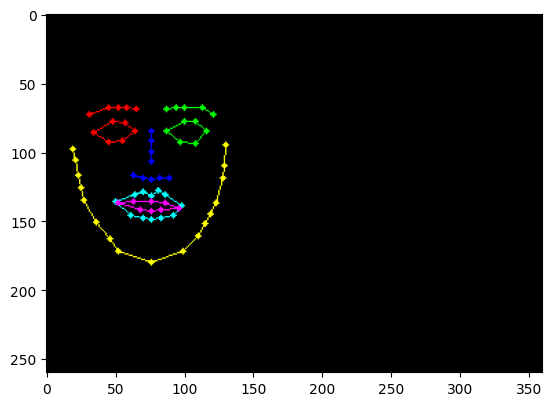

In [199]:
# 加载keypose表情基，测试表情关键点
keypose = np.load("keypose.npy") #(10,68,2) 10 faces, 68 keypoints, 2 coordinates
testpose = np.load("test.npy")  #(2,68,2) 2 faces, 68 keypoints, 2 coordinates

print(len(keypose))
print(len(keypose))
for kp in keypose:
    plt.imshow(drawFace(kp))
    # plt.show()

print(len(testpose))
for tp in testpose:
    print(tp.shape)
    plt.imshow(drawFace(tp))
    plt.show()

testpose_opt = 0
testpose=testpose[testpose_opt]
# plt.imshow(drawFace(testpose))

In [200]:
'''
第一步将表情基分开
0-7为嘴的动作
8-9为眼睛/眉毛的动作
'''

keyposes_mouth = keypose[0:8] #(8,68,2)
keyposes_brows = keypose[[0,8,9],:] #(3,68,2)

width_points = testpose[67][0]-testpose[51][0] #脸宽

# 处理嘴部

In [201]:
'''
将表情基的人脸关键点与当前表情关键点对齐
可以用于处理局部关键点，源码中分别处理眼、嘴
'''
def shiftKeyPoses(new_width, centroid, keyposes, config):   
    #Scale keypose based on head width to accomodate for translation or different video size.
    width_keypose = (keyposes[0][67][0]-keyposes[0][51][0]) # 表情基中第一个姿态的人脸宽度
    width_fac = width_keypose/new_width # 表情基脸宽/真人脸宽
    
    keyposes = np.divide(keyposes, [width_fac,width_fac]).astype(int) # 依据比例系数，将所有表情基关键点缩放到真人面部大小
    
    new_poses = []
    
    for i in range(keyposes.shape[0]): # 遍历所有的表情基
        #For brows we take average of eyes points
        if config == 'brows': 
            keypose = np.array(keyposes[i][10:22])
        #Fo mouth we take average of mouth points
        if config == 'mouth':
            keypose = np.array(keyposes[i][31:51])
            
        centroid_keypose = keypose.mean(0) #表情基中眉毛或者嘴部的中心
        delta = centroid_keypose-centroid # 表情基眉毛或嘴中心与真人眉毛或嘴中心的偏移量
        
        new_pose = keyposes[i]-delta.astype(int) # 利用中心偏移量 重新调整表情基的位置
        new_poses.append(new_pose) # 将新的表情基加入数组中返回
        
    return np.array(new_poses)

In [202]:
'''
嘴部BS
'''
# 对齐keypose和真人嘴部关键点
mouth_center = testpose[31:51].mean(0)
shift_kps_mouth = shiftKeyPoses(width_points,mouth_center,keyposes_mouth,"mouth") # (8,68,2)
# 重组嘴部坐标，便于计算
target_mouth = testpose[31:51].reshape((1,-1)) # (1,40)
dict_2d_mouth = [] # 由于采用了8个keypose，每个keypose有20个关键点，每个关键点有xy两个坐标，所以总共有8*40个坐标
for i in range(shift_kps_mouth.shape[0]):
    dict_2d_mouth.extend(shift_kps_mouth[i][31:51])
dict_2d_mouth = np.array(dict_2d_mouth).reshape(shift_kps_mouth.shape[0],-1) # (8,40)
# 提取嘴部运动的系数，利用SparseCoder这个线性方程求解方法
coder = SparseCoder(dictionary=dict_2d_mouth.astype("float32"),transform_n_nonzero_coefs=None,transform_alpha=10,transform_algorithm='lasso_lars')
coeffs = coder.transform(target_mouth.astype("float32")) # (1,8)
coder, coeffs

(SparseCoder(dictionary=array([[ 53., 143.,  65., 136.,  71., 134.,  76., 137.,  81., 134.,  87.,
         136.,  99., 143.,  92., 148.,  83., 148.,  76., 148.,  72., 148.,
          63., 148.,  55., 144.,  66., 142.,  76., 142.,  86., 142.,  97.,
         144.,  83., 142.,  76., 142.,  69., 142.],
        [ 59., 139.,  67., 125.,  71., 122.,  76., 126.,  81., 122.,  86.,
         125.,  93., 139.,  91., 154.,  83., 165.,  76., 167.,  71., 166.,
          64., 159.,  61., 142.,  68., 131.,  76., 131.,  85...
         131.,  92., 141.,  88., 151.,  82., 156.,  76., 158.,  72., 157.,
          65., 154.,  63., 143.,  68., 136.,  76., 134.,  84., 136.,  90.,
         143.,  80., 150.,  76., 152.,  72., 150.],
        [ 62., 144.,  68., 136.,  72., 133.,  76., 137.,  80., 133.,  84.,
         136.,  91., 144.,  87., 148.,  81., 148.,  76., 149.,  73., 148.,
          68., 148.,  63., 144.,  71., 142.,  76., 142.,  81., 142.,  90.,
         145.,  80., 141.,  76., 141.,  72., 141.]], dtype=

# 处理眉毛

In [203]:
'''
眉毛BS：
眉毛向上的BS系数：通过简单的判断
'''
# 计算眉毛
def calBrow(points, keyposes, config, config2):
    # 眉毛姿态集中，分别有正常，眉毛上，眉毛下
    if config == 'left':
        first = 5
        last = 10
    if config == 'right':
        first = 0
        last = 5
    if config2 == "up":
        target = 1 # 眉毛上
    else:
        target = 2 # 眉毛下
    # 计算挑眉的keypose相对于自然表情下眉毛移动
    deltashifted = keyposes[target][first:last] - keyposes[0][first:last]
    deltashifted = (sum(sum(abs(deltashifted))))
    # 计算当前人脸相对于自然表情下眉毛移动
    deltapoints = (points[first:last]) - (keyposes[target][first:last])
    deltapoints = (sum(sum(abs(deltapoints))))
    # 直接相除，得到比例系数
    if deltapoints < (deltashifted):
        val = 1 - (deltapoints / deltashifted)
    else:
        val = 0.0
    # 如果是眉毛向下，可以用垂直比例来辅助计算，不然不准
    if(target==2):
        ydelt  = keypose[2][first:last] - points[first:last]
        ydelt = sum(ydelt.T[1])
        if(ydelt<=0):
            val = 1.0
    return val

# 约束
def constraint(val,lower,upper):
    factor = 1 / lower
    if lower > val:
        new_val = 0.0
    if lower <= val < upper:
        new_val = (val - lower) * factor
    if val >= upper:
        new_val = 1.0
    return new_val

In [204]:
# 对齐眉毛关键点
eye_center = testpose[10:22].mean(0)
shift_kps_eye = shiftKeyPoses(width_points,eye_center,keyposes_brows,"brows")
# 分别提取左右眉毛上下运动的系数
val_l_up = calBrow(testpose,shift_kps_eye,"left","up")
val_r_up = calBrow(testpose,shift_kps_eye,"right","up")
val_l_down = constraint(calBrow(testpose,shift_kps_eye,"left","down"),0.4,0.8)
val_r_down = constraint(calBrow(testpose,shift_kps_eye,"right","down"),0.4,0.8)

# 眨眼

In [205]:
#左眼
eye_top_r = testpose[11:13].mean(0)
eye_mid_r = testpose[[10,13]].mean(0)
eye_bottom_r = testpose[14:16].mean(0)
blink_r_coeff = (eye_top_r[1]-eye_mid_r[1]+28)/48
squint_r_coeff = (eye_mid_r[1]-eye_bottom_r[1]+17)/7.5
#右眼
eye_top_l = testpose[17:19].mean(0)
eye_mid_l = testpose[[16,19]].mean(0)
eye_bottom_l = testpose[20:22].mean(0)
blink_l_coeff = (eye_top_l[1]-eye_mid_l[1]+28)/48
squint_l_coeff = (eye_mid_l[1]-eye_bottom_l[1]+17)/7.5

In [206]:
def getVerts(obj_path):
    vertices = []
    for line in open(obj_path, "r"):
        values = line.split()
        if(values==[]):
            continue
        if(values=='#'):
            continue
        if 'v' in values: # 这行的含义更直白，与write相对应
        # if(values[0]=='v'):
            vertices.append([float(values[1]),float(values[2]),float(values[3])])    
    return np.array(vertices)

def writeResult(newVert):
    Basic_path = "./data/Basis.obj"
    output_path = "./test/output_testpose{0}.obj".format(testpose_opt)

    with open(Basic_path, 'r') as f_in:
        contents = f_in.readlines()

    # change 'v' lines in Basic.obj
    i = 0
    for idx in range(len(contents)):
        if 'v ' in contents[idx]: # 意思是对于v, vt, vn都有写入
            contents[idx] = "v {0} {1} {2}\n".format(str(newVert[i][0]), str(newVert[i][1]), str(newVert[i][2]))
            i += 1

    with open(output_path, 'w') as f_out:
        f_out.writelines(contents)
    

In [207]:
basicVerts = getVerts('./data/Basis.obj')

In [208]:
# 获取BS偏移量
# 0：Neutral
basicVerts = getVerts('./data/Basis.obj')
# 1：Jaw Open
jawopenVerts = getVerts('./data/jawOpen.obj')
# 2：Closed Smile
closesmileVerts = getVerts('./data/mouthSmile.obj')
# 3：Smile Left
smileleftVerts = getVerts('./data/mouthSmileLeft.obj')
# 4：Smile Right
smilerightVerts = getVerts('./data/mouthSmileRight.obj')
# 5：Mouth Frown
mouthfrownVerts = getVerts('./data/mouthFrown.obj')
# 6：Lip Funnel
lipfunnelVerts = getVerts('./data/mouthFunnel.obj')
# 7：Lip Pucker
lippuckerVerts = getVerts('./data/mouthPucker.obj')

offset = []
offset.append(basicVerts-basicVerts)
offset.append(jawopenVerts-basicVerts)
offset.append(closesmileVerts-basicVerts)
offset.append(smileleftVerts-basicVerts)
offset.append(smilerightVerts-basicVerts)
offset.append(mouthfrownVerts-basicVerts)
offset.append(lipfunnelVerts-basicVerts)
offset.append(lippuckerVerts-basicVerts)

offset = np.array(offset,dtype="float32")

In [209]:
# 根据系数组合BS
newVert = basicVerts
for i in range(offset.shape[0]):
    newVert = newVert + coeffs[0,i]*offset[i]
    # print(coeffs[0,i])
    # print(offset[i])
    # print(newVert)
writeResult(newVert)